首先，导入所需的包

In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

### 访问和读取数据集

In [2]:
train_data = pd.read_csv('./data/train.csv')  # 训练数据
train_data.head()  # 查看开头几行,默认5

,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera


In [3]:
train_data.describe()

,image,label
count,18353,18353
unique,18353,176
top,images/11895.jpg,maclura_pomifera
freq,1,353


In [4]:
test_data = pd.read_csv('./data/test.csv')  # 测试数据
test_data.head()

,image
0,images/18353.jpg
1,images/18354.jpg
2,images/18355.jpg
3,images/18356.jpg
4,images/18357.jpg


In [5]:
print(train_data.shape)
print(test_data.shape)

(18353, 2)
(8800, 1)


### 整理数据集

将训练数据集和测试数据集划分开，然后将训练数据集中每一个类建立一个文件夹，并把标签对应的图片复制一份到里面

In [6]:
def read_csv_labels(fname):
    """读取 `fname` 来给标签字典返回一个文件名。"""
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))


labels = read_csv_labels(os.path.join('./data', 'train.csv')) # 存放训练集标签的文件
print('# 训练样本：',len(labels))
print('# 类别：',len(set(labels.values())))

# 训练样本： 18353
# 类别： 176


In [7]:
def copyfile(filename, target_dir):
    """将文件复制到目标目录。"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)
    

def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    # 下面的collections.Counter就是统计label这个字典中有几个类别（返回字典）；.most_common()则转换成元组；[-1][1]则返回最后一个元组的第二个值(因为这个类别数量最小)
    n = collections.Counter(labels.values()).most_common()[-1][1] # 训练数据集中样本最少的类别中的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio)) # 验证集中每个类别的样本数
    label_count = {}
    for train_file in labels: # 返回训练集中的图片名字列表(我们看到，训练标签转换成的字典，key就是训练集的图片名字)
        label = labels[train_file] # 每张图片对应的标签
        fname = os.path.join(data_dir, train_file) # 每个图片的完整路径
        copyfile(
            fname,
            os.path.join(data_dir, 'train_valid_test', 'train_valid', label)) # 将图片复制到指定的目录下，这个是为了交叉验证使用，这里和训练集没区别
        if label not in label_count or label_count[label] < n_valid_per_label: # 制作验证集。注：标签名作为key,value为每个标签的图片数量
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1 # 统计每个标签的图片数量
        else: # 制作训练集
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label # 返回验证集的数量


In [8]:
def reorg_test(data_dir):
    """在预测期间整理测试集，以方便读取"""
    test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
    for test_file in test['image']: # 获取测试集图片的名字，复制到指定文件夹下
        copyfile(
            os.path.join(data_dir, test_file),
            os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

In [9]:
def reorg_leave_data(data_dir, valid_ratio):
    """调用前面定义的函数，进行整理数据集"""
    labels = read_csv_labels(os.path.join(data_dir, 'train.csv')) # 是个字典
    reorg_train_valid(data_dir, labels, valid_ratio) # 生成训练集和验证集
    reorg_test(data_dir) # 生成测试集

In [10]:
batch_size = 128
valid_ratio = 0.1 # 验证集的比例
if not os.path.exists("./data" + "\\" + "train_valid_test"): # 判断是否已经制作好了数据集
    print("start!")
    reorg_leave_data("./data", valid_ratio)
else:
    print("Already exists!")
print('finish!')

Already exists!
finish!


### 图像增广

In [11]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0), # 从图片的中心点剪裁出24*24的图片
                                             ratio=(3.0 / 4.0, 4.0 / 3.0)),
    torchvision.transforms.RandomHorizontalFlip(), # 左右翻转
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                       saturation=0.4),
    # 加入随机噪音
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], # 对图片的每个通道做均值和方差
                                     [0.229, 0.224, 0.225])])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    # 加入随机噪音
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], # 依然 对图片的每个通道做均值和方差
                                     [0.229, 0.224, 0.225])])


### 读取数据

In [12]:
# ImageFolder按照文件夹顺序，进行打标签

# 训练集和交叉验证集
train_ds, train_valid_ds = [ 
    torchvision.datasets.ImageFolder(
        os.path.join("./data", 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']]

# 验证集和测试集
valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join("./data", 'train_valid_test', folder),
        transform=transform_test) for folder in ['valid', 'test']]

# 把前面的数据放入torch的DataLoader，则每次迭代时，读取一个batch
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)


### 定义模型

In [13]:
def resnet18(num_classes, in_channels=1):
    """稍加修改的ResNet-18模型"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(
        64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

In [14]:
def get_net():
    num_classes = 176
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

### 训练函数

In [15]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0]) # 特征和标签都放到gpu
            trainer.zero_grad() # 梯度清零
            output = net(features) # 得出预测结果
            l = loss(output, labels).sum()
            l.backward() # 反向传播，求梯度
            trainer.step() # 更新参数
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

RuntimeError: CUDA out of memory. Tried to allocate 1.53 GiB (GPU 0; 6.00 GiB total capacity; 4.71 GiB already allocated; 0 bytes free; 4.73 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

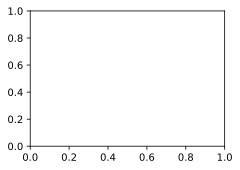

In [16]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)